In [1]:
from data_imports import *
from data_clean import data, GEOS_FP_A1_data
CVAO_df = data()
GEOS_df = GEOS_FP_A1_data()

In [2]:
class MODEL:
    def __init__(self, input_data, target_var, model):
        """
        Initialize the Model with input data and target variable.

        :param input_data: DataFrame containing the input data.
        :param target_var: Name of the target variable column.
        """
        self.input_data = input_data
        self.target_var = target_var
        self.model = model
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.train_test_metrics = None
        
    def prepare_data(self):
        """
        Prepare data by separating features and target variable,
        and splitting into training and testing sets.
        """
        df_not_missing = self.input_data.dropna(subset=[self.target_var])
        X = df_not_missing.drop(columns=[self.target_var])
        y = df_not_missing[self.target_var]
        
        # Split the data into train and test subsets.
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=1
        )
    
    def train_model(self):
        """
        Train the HistGradientBoostingRegressor model.
        """
        if self.X_train is None or self.y_train is None:
            raise ValueError("Data has not been prepared. Call prepare_data() first.")
        self.model.fit(self.X_train, self.y_train)
    
    def predict(self, new_data):
        """
        Predict target values for new data using the trained model.

        :param new_data: DataFrame containing the new input data.
        :return: Array of predicted values.
        """
        if self.model is None:
            raise ValueError("Model has not been trained. Call train_model() first.")
        return self.model.predict(new_data)
    
    def fill_missing_values(self):
        """
        Predict and fill missing values in the original input data.
        
        :return: DataFrame with missing values filled.
        """
        if self.X_train is None or self.y_train is None:
            raise ValueError("Data has not been prepared. Call prepare_data() first.")
        if self.model is None:
            raise ValueError("Model has not been trained. Call train_model() first.")
        
        df_missing = self.input_data[self.input_data[self.target_var].isnull()]
        if not df_missing.empty:
            X_missing = df_missing.drop(columns=[self.target_var])
            self.input_data.loc[self.input_data[self.target_var].isnull(), self.target_var] = self.model.predict(X_missing)
        
        return self.input_data
    
    def evaluate_model(self):
        """
        Evaluate the model using regression metrics for both training and testing sets.
        """
        if self.X_train is None or self.y_train is None:
            raise ValueError("Data has not been prepared. Call prepare_data() first.")
        if self.model is None:
            raise ValueError("Model has not been trained. Call train_model() first.")
        
        # Predictions on the training and test set.
        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        # Calculating regression metrics for the training set.
        mse_train = mean_squared_error(self.y_train, y_train_pred)
        rmse_train = mse_train ** 0.5
        mae_train = mean_absolute_error(self.y_train, y_train_pred)
        r2_train = r2_score(self.y_train, y_train_pred)

        # Calculating regression metrics for the test set.
        mse_test = mean_squared_error(self.y_test, y_test_pred)
        rmse_test = mse_test ** 0.5
        mae_test = mean_absolute_error(self.y_test, y_test_pred)
        r2_test = r2_score(self.y_test, y_test_pred)
        
        self.train_test_metrics = {
            'train': {'mse': mse_train, 'rmse': rmse_train, 'mae': mae_train, 'r2': r2_train},
            'test': {'mse': mse_test, 'rmse': rmse_test, 'mae': mae_test, 'r2': r2_test}
        }

        # Print training and testing set regression metrics.
        print(f'Training Set - MSE: {mse_train:8.5f}, RMSE: {rmse_train:8.5f}, MAE: {mae_train:8.5f}, R2: {r2_train:8.5f}')
        print(f'Testing Set  - MSE: {mse_test:8.5f}, RMSE: {rmse_test:8.5f}, MAE: {mae_test:8.5f}, R2: {r2_test:8.5f}')
    
    def model_metrics(self):
        """
        Model evaluation metrics, used for plots.
        
        :return: Dictionary of training and testing metrics.
        """
        if self.X_train is None or self.y_train is None:
            raise ValueError("Data has not been prepared. Call prepare_data() first.")
        if self.model is None:
            raise ValueError("Model has not been trained. Call train_model() first.")

        return self.train_test_metrics
    
    def shap_summary(self, file_name, title):
        """
        Summarise the top SHAP features for the model.
        """
        if self.X_train is None or self.y_train is None:
            raise ValueError("Data has not been prepared. Call prepare_data() first.")
        if self.model is None:
            raise ValueError("Model has not been trained. Call train_model() first.")
            
        # SHAP analysis
        explainer = shap.Explainer(self.model)
        self.shap_values = explainer.shap_values(self.X_test)
        shap.summary_plot(self.shap_values, self.X_test, show = False)
        
        plt.title(title)
        plt.savefig(f'/Users/callumwilson/Documents/GitHub/ML-Project/Output/{file_name}.png', bbox_inches='tight')
        plt.show()
    
    def shap_top_features(self, top_n):
        """
        Calculate and return the top N features based on SHAP values.

        :param top_n: Number of top features to return.
        :return: DataFrame with the top N features and the target variable.
        """
        if self.X_train is None or self.y_train is None:
            raise ValueError("Data has not been prepared. Call prepare_data() first.")
        if self.model is None:
            raise ValueError("Model has not been trained. Call train_model() first.")

        # Calculate mean absolute SHAP values for each feature
        shap_importance = np.abs(self.shap_values).mean(axis=0)
        top_n_indices = np.argsort(shap_importance)[-top_n:][::-1]  # Indices of the top N features
        top_n_features = self.X_test.columns[top_n_indices]
        
        # Return DataFrame with top N features and target variable
        return self.input_data[top_n_features.to_list() + [self.target_var]]
    
    def feature_importance(self, features, file_name):
        
        feature_range = range(1, features + 1)

        metrics = {
        'MSE': {'train': [], 'test': []},
        'RMSE': {'train': [], 'test': []},
        'MAE': {'train': [], 'test': []},
        'R2': {'train': [], 'test': []}
        }
        
        for feature in feature_range:
            # Get the top `feature` number of SHAP features
            selected_features = self.shap_top_features(feature)  # Get the DataFrame with top `feature` features

            # Create a new MODEL instance with the selected features
            new_model = MODEL(input_data=selected_features, target_var=self.target_var, model=self.model)

            # Prepare the data for the new model
            new_model.prepare_data()

            # Train the new model
            new_model.train_model()

            # Evaluate the new model
            new_model.evaluate_model()
            
            # Get the metrics from the evaluation and append them to the lists
            metrics['MSE']['train'].append(new_model.train_test_metrics['train']['mse'])
            metrics['MSE']['test'].append(new_model.train_test_metrics['test']['mse'])

            metrics['RMSE']['train'].append(new_model.train_test_metrics['train']['rmse'])
            metrics['RMSE']['test'].append(new_model.train_test_metrics['test']['rmse'])

            metrics['MAE']['train'].append(new_model.train_test_metrics['train']['mae'])
            metrics['MAE']['test'].append(new_model.train_test_metrics['test']['mae'])

            metrics['R2']['train'].append(new_model.train_test_metrics['train']['r2'])
            metrics['R2']['test'].append(new_model.train_test_metrics['test']['r2'])

        # Plotting the metrics
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))

        # Flatten the axes array to easily loop through them
        axs = axs.flatten()
        
        # Metric names for the legend and titles
        metric_names = ['MSE', 'RMSE', 'MAE', 'R2']

        for i, metric in enumerate(metrics.values()):
            axs[i].plot(feature_range, metric['train'], marker='o', label=f'Training {list(metrics)[i]}')
            axs[i].plot(feature_range, metric['test'], marker='o', label=f'Testing {list(metrics)[i]}')
            axs[i].set_title(f'{list(metrics)[i]} Over Top {features} Features')
            axs[i].set_xlabel('Number of Features')
            axs[i].set_ylabel(list(metrics)[i])
            axs[i].legend()
            axs[i].grid(True)
            axs[i].set_xticks(range(1, features + 1))
            
        # Adjust layout to avoid overlap
        plt.tight_layout()
        plt.savefig(f'/Users/callumwilson/Documents/GitHub/ML-Project/Output/{file_name}.png', bbox_inches='tight')
        plt.show()


In [66]:
from xgboost import XGBRegressor

mod = XGBRegressor()
CVAO = MODEL(CVAO_df, 'O3_ppbV', mod)

print('Preparing Model')
CVAO.prepare_data()
print('Training Model')
CVAO.train_model()
print('Evaluating Model')
CVAO.evaluate_model()

CVAO_data = CVAO.model_metrics()

merged = pd.merge(CVAO_df, GEOS_df, left_index=True, right_index=True, how='outer')

GEOS_CVAO = MODEL(merged, 'O3_ppbV', mod)
print('Preparing Model')
GEOS_CVAO.prepare_data()
print('Training Model')
GEOS_CVAO.train_model()
print('Evaluating Model')
GEOS_CVAO.evaluate_model()

GEOS_CVAO_data = GEOS_CVAO.model_metrics()

Preparing Model
Training Model
Evaluating Model
Training Set - MSE:  8.49411, RMSE:  2.91447, MAE:  2.15640, R2:  0.84411
Testing Set  - MSE:  9.85536, RMSE:  3.13933, MAE:  2.36101, R2:  0.81934
Preparing Model
Training Model
Evaluating Model
Training Set - MSE:  8.41547, RMSE:  2.90094, MAE:  2.12136, R2:  0.84555
Testing Set  - MSE:  9.61925, RMSE:  3.10149, MAE:  2.31095, R2:  0.82367


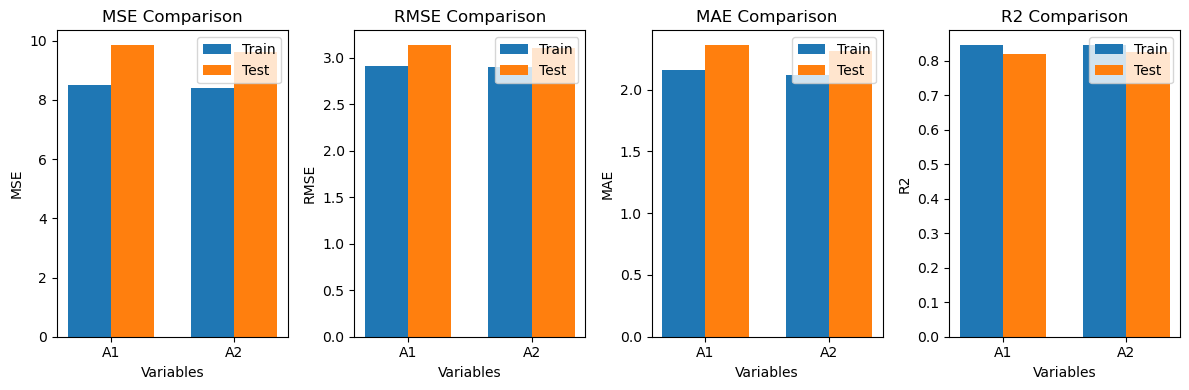

In [125]:
B1 = {'A1':CVAO_data, 'A2':GEOS_CVAO_data}

metrics = ['mse', 'rmse', 'mae', 'r2']
variables = ['A1', 'A2']

fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    ax = axs[i]
    
    train_values = [B1[var]['train'][metric] for var in variables]
    test_values = [B1[var]['test'][metric] for var in variables]
    
    x = np.arange(len(variables))
    width = 0.35
    
    ax.bar(x - width/2, train_values, width, label='Train')
    ax.bar(x + width/2, test_values, width, label='Test')
    
    ax.set_xlabel('Variables')
    ax.set_ylabel(metric.upper())
    ax.set_title(f'{metric.upper()} Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(variables)
    ax.legend()

plt.tight_layout()
plt.savefig(f'/Users/callumwilson/Documents/GitHub/ML-Project/Output/Metric_Comp_1', bbox_inches='tight')

plt.show()

Preparing Model
Training Model
Evaluating Model
Training Set - MSE:  2.63349, RMSE:  1.62280, MAE:  1.23083, R2:  0.94943
Testing Set  - MSE:  4.19328, RMSE:  2.04775, MAE:  1.58563, R2:  0.92033
Model SHAP Summary


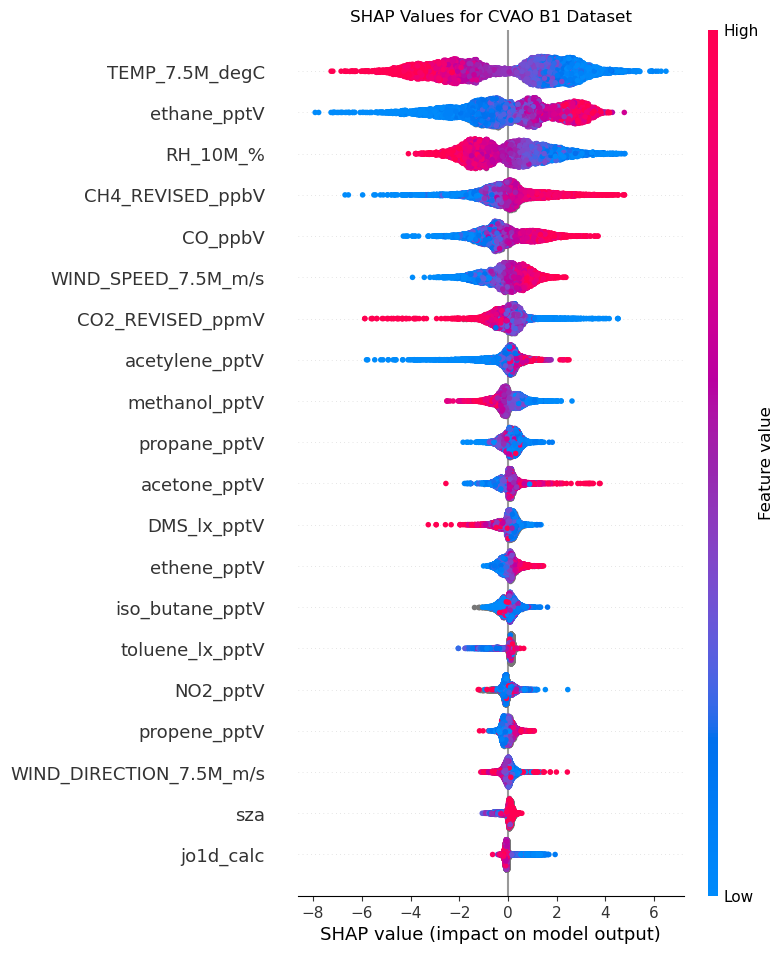

Preparing Model
Training Model
Evaluating Model
Training Set - MSE:  1.70943, RMSE:  1.30745, MAE:  1.00171, R2:  0.96718
Testing Set  - MSE:  3.14142, RMSE:  1.77240, MAE:  1.35974, R2:  0.94032
Model SHAP Summary


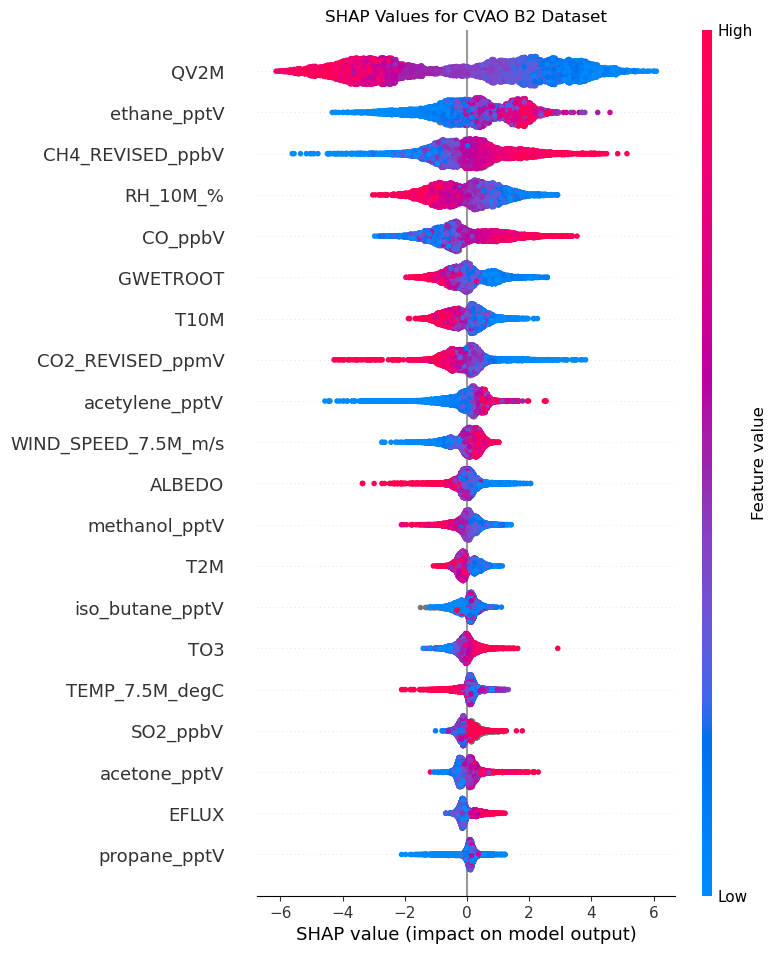

In [136]:
CVAO_filt = CVAO_df[CVAO_df.index.isin(GEOS_df.index)]
CVAO_F = MODEL(CVAO_filt, 'O3_ppbV', mod)

print('Preparing Model')
CVAO_F.prepare_data()
print('Training Model')
CVAO_F.train_model()
print('Evaluating Model')
CVAO_F.evaluate_model()
print('Model SHAP Summary')
CVAO_F.shap_summary(file_name = 'CVAO_SHAP', title = 'SHAP Values for CVAO B1 Dataset')

CVAO_F_data = CVAO_F.model_metrics()

merged = pd.merge(CVAO_filt, GEOS_df, left_index=True, right_index=True, how='outer')

GEOS_CVAO_F = MODEL(merged, 'O3_ppbV', mod)
print('Preparing Model')
GEOS_CVAO_F.prepare_data()
print('Training Model')
GEOS_CVAO_F.train_model()
print('Evaluating Model')
GEOS_CVAO_F.evaluate_model()
print('Model SHAP Summary')
GEOS_CVAO_F.shap_summary(file_name = 'GEOS_CVAO_SHAP', title = 'SHAP Values for CVAO B2 Dataset')

GEOS_CVAO_F_data = GEOS_CVAO_F.model_metrics()

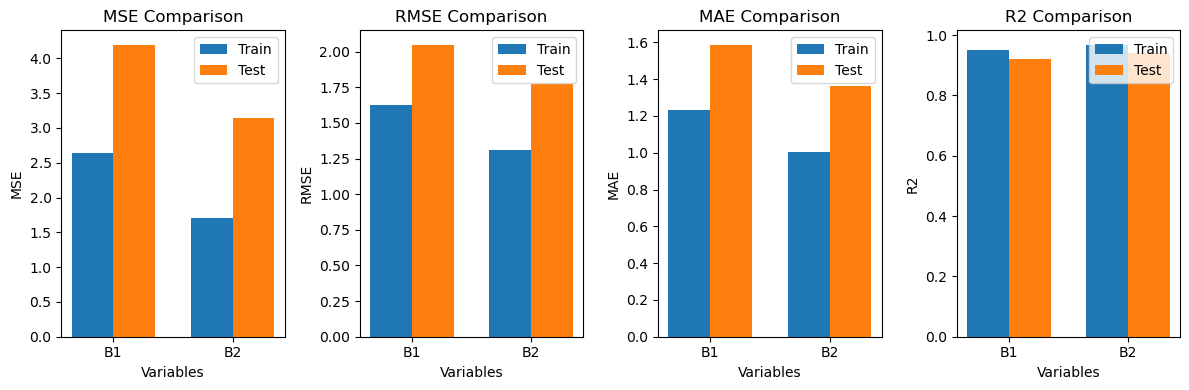

In [124]:
B2 = {'B1':CVAO_F_data, 'B2':GEOS_CVAO_F_data}

metrics = ['mse', 'rmse', 'mae', 'r2']
variables = ['B1', 'B2']

fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    ax = axs[i]
    
    train_values = [B2[var]['train'][metric] for var in variables]
    test_values = [B2[var]['test'][metric] for var in variables]
    
    x = np.arange(len(variables))
    width = 0.35
    
    ax.bar(x - width/2, train_values, width, label='Train')
    ax.bar(x + width/2, test_values, width, label='Test')
    
    ax.set_xlabel('Variables')
    ax.set_ylabel(metric.upper())
    ax.set_title(f'{metric.upper()} Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(variables)
    ax.legend()

plt.tight_layout()
plt.savefig(f'/Users/callumwilson/Documents/GitHub/ML-Project/Output/Metric_Comp_2', bbox_inches='tight')

plt.show()

In [133]:
print('Model SHAP Summary')
CVAO_F.shap_summary(file_name = 'CVAO_SHAP', title = 'SHAP Values for CVAO B1 Dataset')

Model SHAP Summary


XGBoostError: [19:55:09] /Users/runner/work/xgboost/xgboost/src/c_api/c_api_utils.h:129: Check failed: std::accumulate(shape.cbegin(), shape.cend(), static_cast<bst_ulong>(1), std::multiplies<>{}) == chunksize * rows (1022385 vs. 1480024) : 
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000178a6c58c dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000178aedf08 xgboost::CalcPredictShape(bool, xgboost::PredictionType, unsigned long, unsigned long, unsigned long, unsigned long, unsigned long, std::__1::vector<unsigned long long, std::__1::allocator<unsigned long long> >*, unsigned long long*) + 1224
  [bt] (2) 3   libxgboost.dylib                    0x0000000178aed328 XGBoosterPredictFromDMatrix + 1228
  [bt] (3) 4   libffi.8.dylib                      0x00000001013dc04c ffi_call_SYSV + 76
  [bt] (4) 5   libffi.8.dylib                      0x00000001013d97d4 ffi_call_int + 1336
  [bt] (5) 6   _ctypes.cpython-310-darwin.so       0x00000001013bc128 _ctypes_callproc + 944
  [bt] (6) 7   _ctypes.cpython-310-darwin.so       0x00000001013b6408 PyCFuncPtr_call + 228
  [bt] (7) 8   python3.10                          0x0000000100837334 _PyEval_EvalFrameDefault + 59080
  [bt] (8) 9   python3.10                          0x000000010071bcf4 _PyFunction_Vectorcall + 548



In [26]:
CVAO_8 = MODEL(CVAO_top8, 'O3_ppbV', mod)

print('Preparing Model')
CVAO_8.prepare_data()
print('Training Model')
CVAO_8.train_model()
print('Evaluating Model')
CVAO_8.evaluate_model()

CVAO_8_data = CVAO_8.model_metrics()
display(CVAO_8_data)

Preparing Model
Training Model
Evaluating Model
Training Set - MSE: 13.51293, RMSE:  3.67599, MAE:  2.80828, R2:  0.75200
Testing Set  - MSE: 13.83313, RMSE:  3.71929, MAE:  2.85983, R2:  0.74643


{'train': {'mse': 13.51292877269886,
  'rmse': 3.675993576259194,
  'mae': 2.8082756610033823,
  'r2': 0.751999467422037},
 'test': {'mse': 13.833132541838845,
  'rmse': 3.7192919409262357,
  'mae': 2.8598348849454096,
  'r2': 0.746427318853488}}

In [27]:
merged_df_outer = pd.merge(CVAO_top8, GEOS_df, left_index=True, right_index=True, how='outer')

GEOS_CVAO_8_outer = MODEL(merged_df_outer, 'O3_ppbV', mod)
print('Preparing Model')
GEOS_CVAO_8_outer.prepare_data()
print('Training Model')
GEOS_CVAO_8_outer.train_model()
print('Evaluating Model')
GEOS_CVAO_8_outer.evaluate_model()

GEOS_CVAO_8_outer_data = GEOS_CVAO_8_outer.model_metrics()
display(GEOS_CVAO_8_outer_data)

Preparing Model
Training Model
Evaluating Model
Training Set - MSE: 12.79318, RMSE:  3.57675, MAE:  2.70421, R2:  0.76521
Testing Set  - MSE: 13.09840, RMSE:  3.61917, MAE:  2.75893, R2:  0.75990


{'train': {'mse': 12.793175387418023,
  'rmse': 3.57675486823154,
  'mae': 2.7042134917330904,
  'r2': 0.7652089815012553},
 'test': {'mse': 13.098401201022094,
  'rmse': 3.6191713417607203,
  'mae': 2.758925175261423,
  'r2': 0.7598955477922175}}

In [106]:
display(len(GEOS_df)/len(CVAO_df))

0.3284474547571172

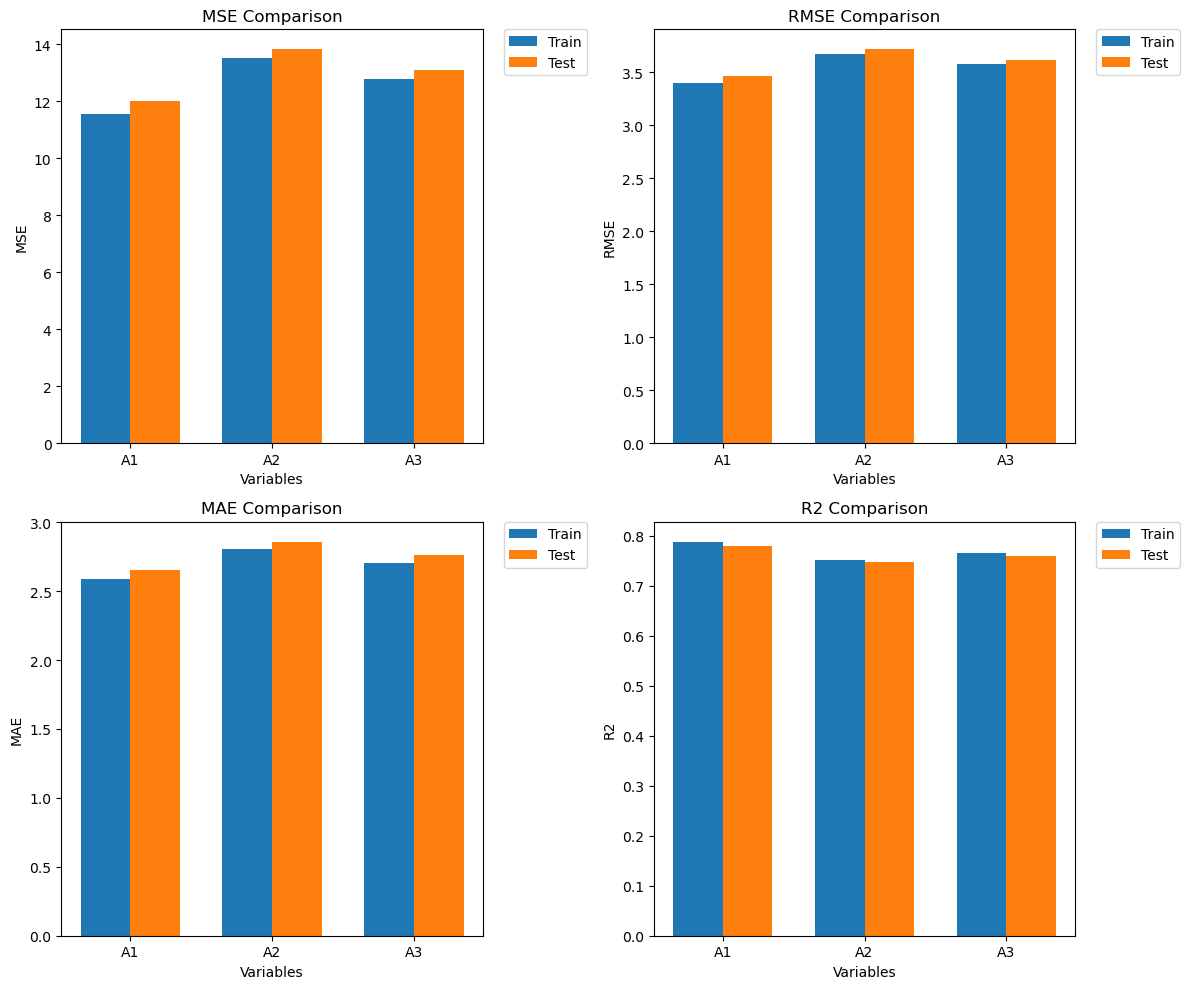

In [41]:
B = {'A1':CVAO_data, 'A2':CVAO_8_data, 'A3': GEOS_CVAO_8_outer_data}

metrics = ['mse', 'rmse', 'mae', 'r2']
variables = ['A1', 'A2', 'A3']

fig, axs = plt.subplots(4, 1, figsize=(12, 10))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    ax = axs[i]
    
    train_values = [B[var]['train'][metric] for var in variables]
    test_values = [B[var]['test'][metric] for var in variables]
    
    x = np.arange(len(variables))
    width = 0.35
    
    ax.bar(x - width/2, train_values, width, label='Train')
    ax.bar(x + width/2, test_values, width, label='Test')
    
    ax.set_xlabel('Variables')
    ax.set_ylabel(metric.upper())
    ax.set_title(f'{metric.upper()} Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(variables)
    ax.legend()
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.savefig(f'/Users/callumwilson/Documents/GitHub/ML-Project/Output/Metric_Comp', bbox_inches='tight')

plt.show()

Training Set - MSE: 33.78832, RMSE:  5.81277, MAE:  4.58315, R2:  0.37989
Testing Set  - MSE: 33.64819, RMSE:  5.80071, MAE:  4.56625, R2:  0.38320
Training Set - MSE: 28.47182, RMSE:  5.33590, MAE:  4.15124, R2:  0.47746
Testing Set  - MSE: 28.80894, RMSE:  5.36740, MAE:  4.17979, R2:  0.47191
Training Set - MSE: 21.16992, RMSE:  4.60108, MAE:  3.56224, R2:  0.61147
Testing Set  - MSE: 21.50217, RMSE:  4.63704, MAE:  3.60723, R2:  0.60585
Training Set - MSE: 17.76998, RMSE:  4.21545, MAE:  3.25573, R2:  0.67387
Testing Set  - MSE: 18.13465, RMSE:  4.25848, MAE:  3.30759, R2:  0.66758
Training Set - MSE: 16.25342, RMSE:  4.03155, MAE:  3.10200, R2:  0.70170
Testing Set  - MSE: 16.65914, RMSE:  4.08156, MAE:  3.15541, R2:  0.69462
Training Set - MSE: 14.75785, RMSE:  3.84159, MAE:  2.94033, R2:  0.72915
Testing Set  - MSE: 15.12193, RMSE:  3.88869, MAE:  2.98890, R2:  0.72280
Training Set - MSE: 14.23579, RMSE:  3.77304, MAE:  2.88561, R2:  0.73873
Testing Set  - MSE: 14.61333, RMSE:  3

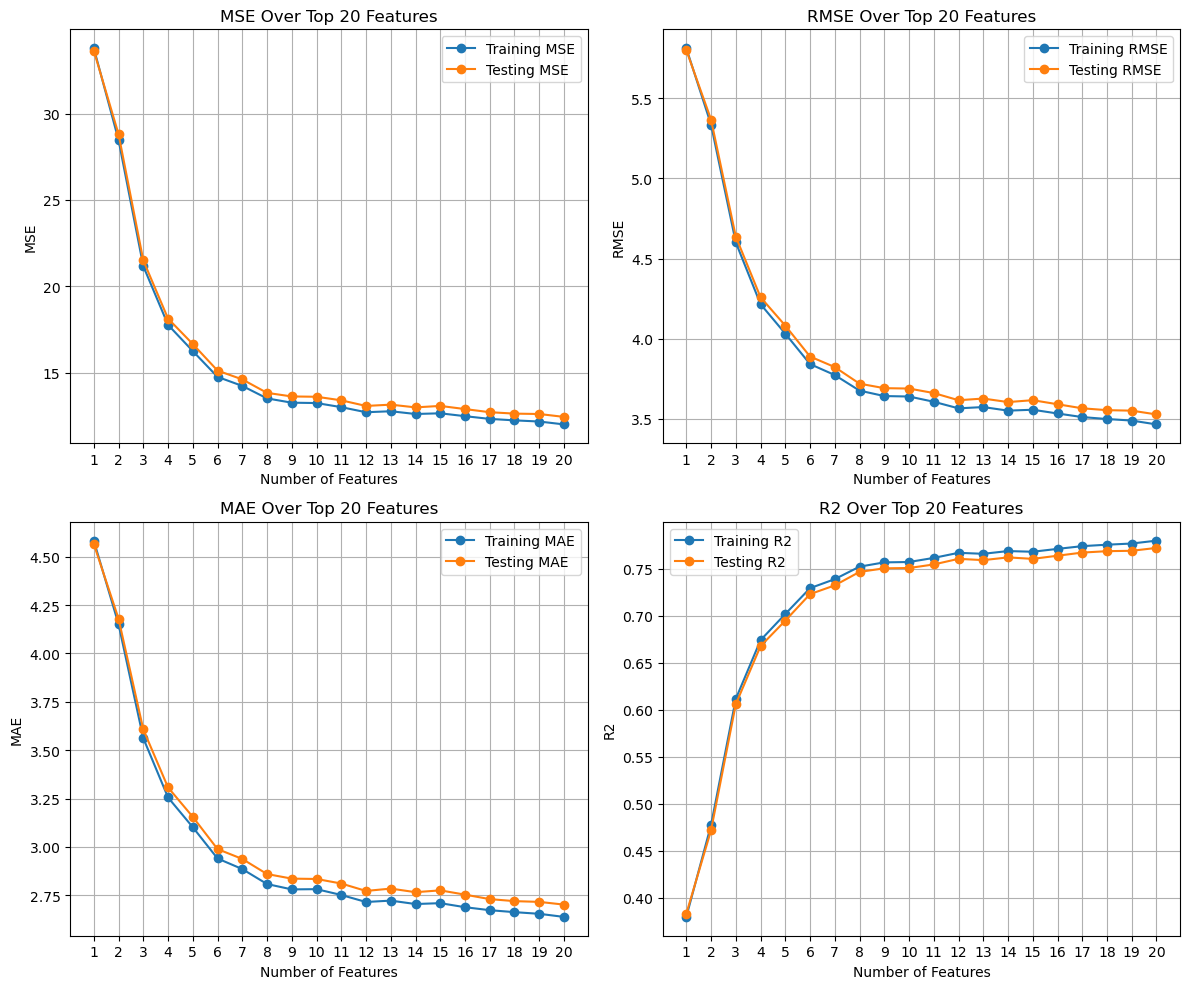

In [66]:
M.feature_importance(20, 'CVAO_metrics')

In [51]:
CVAO_filt = CVAO_df[CVAO_df.index.isin(GEOS_df.index)]
CVAO_F = MODEL(CVAO_filt, 'O3_ppbV', mod)

print('Preparing Model')
CVAO_F.prepare_data()
print('Training Model')
CVAO_F.train_model()
print('Evaluating Model')
CVAO_F.evaluate_model()

CVAO_F_data = CVAO_F.model_metrics()

Preparing Model
Training Model
Evaluating Model
Training Set - MSE:  5.24485, RMSE:  2.29016, MAE:  1.77997, R2:  0.89929
Testing Set  - MSE:  5.88200, RMSE:  2.42528, MAE:  1.89366, R2:  0.88825


In [52]:
merged_df_right = pd.merge(CVAO_top8, GEOS_df, left_index=True, right_index=True, how='right')

GEOS_CVAO_8_right = MODEL(merged_df_right, 'O3_ppbV', mod)
print('Preparing Model')
GEOS_CVAO_8_right.prepare_data()
print('Training Model')
GEOS_CVAO_8_right.train_model()
print('Evaluating Model')
GEOS_CVAO_8_right.evaluate_model()

GEOS_CVAO_8_right_data = GEOS_CVAO_8_right.model_metrics()

Preparing Model
Training Model
Evaluating Model
Training Set - MSE:  4.67188, RMSE:  2.16145, MAE:  1.67347, R2:  0.91029
Testing Set  - MSE:  5.30089, RMSE:  2.30237, MAE:  1.78205, R2:  0.89929


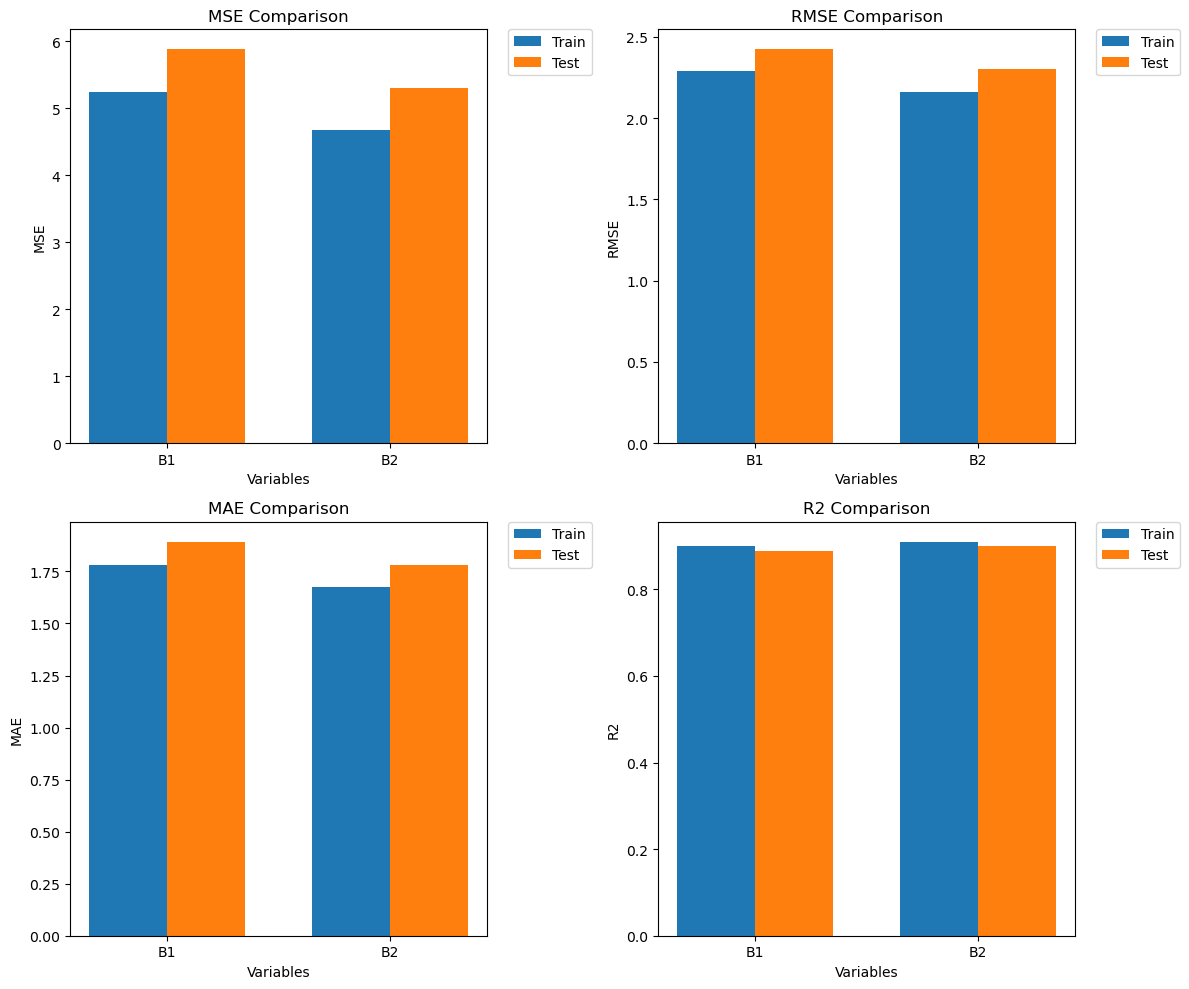

In [54]:
B = {'B1':CVAO_F_data, 'B2':GEOS_CVAO_8_right_data}

metrics = ['mse', 'rmse', 'mae', 'r2']
variables = ['B1', 'B2']

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    ax = axs[i]
    
    train_values = [B[var]['train'][metric] for var in variables]
    test_values = [B[var]['test'][metric] for var in variables]
    
    x = np.arange(len(variables))
    width = 0.35
    
    ax.bar(x - width/2, train_values, width, label='Train')
    ax.bar(x + width/2, test_values, width, label='Test')
    
    ax.set_xlabel('Variables')
    ax.set_ylabel(metric.upper())
    ax.set_title(f'{metric.upper()} Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(variables)
    ax.legend()
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.savefig(f'/Users/callumwilson/Documents/GitHub/ML-Project/Output/Metric_Comp_3', bbox_inches='tight')

plt.show()

In [130]:
print(1 - (0.92033 / 0.94032))

0.021258720435596512
